# Data Engineering Activity
This demonstration is to teach data engineering principles that can be applied to a wide range of datasets and data types. In this case, we are working with a synthetic dataset based on drill data.

## Setup

Run these cells to load in the approprate packages and make sure the notebook has the data accessible. You should run this on a Jupyter Notebook downloaded earlier in the training.

In [1]:
# Uncomment if you want full environment setup
# !pip install -r requirements.txt

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from pandas_profiling import ProfileReport
import pickle
# import tensorflow as tf
warnings.filterwarnings("ignore")
try:
    from rop_utils import ROPData
    data_folder = "../data/"
except ModuleNotFoundError:
    !git clone https://github.com/pvankatwyk/vermeer-training.git
    data_folder = "vermeer-training/data/"

%matplotlib inline

## Step 1: Load Data

The first step is to load the data into Python. The data is currently stored in a Comma Separated Values format (CSV) on your computer's hard drive. In order for python to be able to interface with the data, it will load the data into RAM for easy access and calculation.  

Below are a few different file types that python can handle using the Pandas library. For more information on pandas, see the documentation here:  . The same data is loaded from a CSV file, a TXT file, and a XLSX file. Do they look the same?

In [3]:
# Load data from .csv, .txt, and .xlsx files
csv_data = pd.read_csv(data_folder + 'synthetic_drill_data.csv')
txt_data = pd.read_csv(data_folder + 'synthetic_drill_data.txt', sep='    ')
# xlsx_data = pd.read_excel(data_folder + 'synthetic_drill_data.xlsx', sheet_name='data')

# Are they the same?
equal = all(csv_data == txt_data)
print('The data is equivalent (T/F):', equal)

The data is equivalent (T/F): True


In [4]:
# Load in data for this training
data = pd.read_csv(data_folder + r'synthetic_drill_data_1.csv')
data

,Id,TimeStamp,Model,Latitude,Longitude,RodCount,Rotation Speed Max (rpm),Rotation Torque Max (ft-lb),Thrust Force Max (lbf),Mud Flow Rate Avg (gpm),Mud Pressure Max (psi),Thrust Speed Avg (ft/min),Pull Force Maximum (lbf),Pull Speed Average (ft/min),Drill String Length (ft)
0,89733,11/18/2022 17:41:00,D23X30 S3,48.20,-102.85,2.0,109.0,913.0,8430.0,5.2,61.0,10.0,0.0,0.0,34.0
1,89733,11/18/2022 17:44:07,D23X30 S3,48.20,-102.85,3.0,108.0,989.0,11342.0,5.4,154.0,10.0,0.0,0.0,44.0
2,89733,11/18/2022 17:36:44,D23X30 S3,48.20,-102.85,4.0,NaN,307.0,872.0,4.7,53.0,1.0,1125.0,0.0,34.0
3,89733,11/18/2022 17:46:23,D23X30 S3,48.20,-102.85,2.0,109.0,1048.0,13828.0,8.3,146.0,8.0,0.0,0.0,34.0
4,89733,11/18/2022 18:03:28,D23X30 S3,48.20,-102.85,4.0,113.0,1263.0,16033.0,7.8,474.0,10.0,0.0,0.0,54.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,92106,10/29/2022 19:22:55,D24X40 S3,45.13,-93.42,55.0,190.0,1317.0,10542.0,5.9,83.0,22.0,0.0,0.0,564.0
29996,92106,10/29/2022 18:56:43,D24X40 S3,45.13,-93.42,56.0,176.0,1262.0,14120.0,6.2,112.0,22.0,0.0,0.0,574.0
29997,92106,10/29/2022 19:21:51,D24X40 S3,45.13,-93.42,65.0,177.0,1815.0,14476.0,6.2,87.0,17.0,9963.0,19.0,644.0
29998,92106,10/29/2022 19:28:09,D24X40 S3,44.87,-93.29,55.0,181.0,2110.0,19026.0,6.1,983.0,15.0,9990.0,9.0,564.0


## Step 2: Calculating ROP

The goal for this activity is to learn about and be able to predict the speed of drilling, or Rate of Penetration (ROP). ROP is not a measurement found in the existing data, so we must calculate it and add it to the dataset. We will look at two rows at a time and take the difference in drill depth divided by the difference in timestamps. This will give us a measurement in distance per time (speed), or in our case, feet per minute.

In [5]:
def process(data):
    # Convert to pandas-recognized timestamp
    data['TimeStamp'] = pd.to_datetime(data['TimeStamp'])
    n = len(data)
    # Create an array for storing the data - 
    deltaTime = np.zeros(n) * np.nan  # differences in timestamps
    forward = [True] * n              # whether the drill is moving forward

    # Calculate time stamp differences
    for i in range(1, n):
        deltaTime[i] = (data['TimeStamp'][i] - data['TimeStamp'][i - 1]).total_seconds()
        forward[i] = True if data['RodCount'][i] > data['RodCount'][i - 1] else False

    # average of 2 and 3 for 1st time point only
    deltaTime[0] = np.mean(deltaTime[1:3])
    
    # calculate ROP from deltaTime and 10 feet difference between rods
    data['ROP (ft/min)'] = (60 * 10.0 / deltaTime)
    
    # Only include data when the drill is moving forward
    data = data[forward]
    
    # Drop rows with no time change
    data = data.replace([np.inf, -np.inf], np.nan)
    data = data.reset_index(drop=True)
    
    return data

def filter(data, column, min=None, max=None):
    if max is None:
        max = data[column].max()
    if min is None:
        min = data[column].min()

    return data[(data[column] < max) & (data[column] > min)]

In [6]:
# Process data
processed_data = process(data)

# Filter the data -- ROP > 0
filtered_data = filter(data=processed_data, column='ROP (ft/min)', min=0, max=None)
data = filtered_data.drop(columns=['Id', 'TimeStamp', 'Latitude', 'Longitude', "Thrust Speed Avg (ft/min)"])

In [7]:
data

,Model,RodCount,Rotation Speed Max (rpm),Rotation Torque Max (ft-lb),Thrust Force Max (lbf),Mud Flow Rate Avg (gpm),Mud Pressure Max (psi),Pull Force Maximum (lbf),Pull Speed Average (ft/min),Drill String Length (ft),ROP (ft/min)
1,D23X30 S3,3.0,108.0,989.0,11342.0,5.4,154.0,0.0,0.0,44.0,3.208556
3,D23X30 S3,4.0,113.0,1263.0,16033.0,7.8,474.0,0.0,0.0,54.0,0.585366
4,D23X30 S3,5.0,112.0,1259.0,9954.0,7.5,165.0,0.0,0.0,64.0,5.217391
6,D23X30 S3,8.0,111.0,272.0,3479.0,8.1,148.0,448.0,0.0,94.0,0.093081
8,D23X30 S3,13.0,110.0,703.0,8990.0,7.4,483.0,0.0,0.0,144.0,0.400534
...,...,...,...,...,...,...,...,...,...,...,...
26389,D24X40 S3,56.0,179.0,1855.0,11088.0,5.2,42.0,1255.0,0.0,574.0,2.158273
26390,D24X40 S3,63.0,176.0,1573.0,18802.0,5.6,52.0,2353.0,0.0,644.0,0.609756
26392,D24X40 S3,68.0,185.0,2243.0,20044.0,5.9,78.0,9425.0,50.0,674.0,9.375000
26396,D24X40 S3,65.0,177.0,1815.0,14476.0,6.2,87.0,9963.0,19.0,644.0,0.397878


In [8]:
data.columns

Index(['Model', 'RodCount', 'Rotation Speed Max (rpm)',
       'Rotation Torque Max (ft-lb)', 'Thrust Force Max (lbf)',
       'Mud Flow Rate Avg (gpm)', 'Mud Pressure Max (psi)',
       'Pull Force Maximum (lbf)', 'Pull Speed Average (ft/min)',
       'Drill String Length (ft)', 'ROP (ft/min)'],
      dtype='object')

In [9]:
# You can also do this to get the same output...
# data = ROPData().upload(data_folder + 'synthetic_drill_data.csv').process().filter(rop_greater_than=0)

## Step 3: Removing Bad Data

### Identifying Missing Data  
First we need to identify if our dataset has missing fields. The following code sums the number of values that are missing in each column.

In [10]:
data.isna().sum()

Model                          1
RodCount                       0
Rotation Speed Max (rpm)       1
Rotation Torque Max (ft-lb)    0
Thrust Force Max (lbf)         2
Mud Flow Rate Avg (gpm)        1
Mud Pressure Max (psi)         0
Pull Force Maximum (lbf)       1
Pull Speed Average (ft/min)    1
Drill String Length (ft)       1
ROP (ft/min)                   0
dtype: int64

### Handling Missing Data  
There are a few different ways of handling missing fields within the data. The best way to deal with missing data is to simply delete the entire row where the field is missing. Since the field is empty, there is no way to know what should go there and we ideally don't want to impose prior knowledge into the data.  

However, sometimes the data is not long enough and we cannot afford to delete any of the rows. In that case, you can use imputation, which is a way of filling in the missing field with a logical "best guess" such as the column mean, median, or an interpolation between the row before and after. In this exercise, we will simply delete rows with missing data.

###### Deleting Rows with Missing Information

In [11]:
data = data.dropna()

In [12]:
data.isna().sum()

Model                          0
RodCount                       0
Rotation Speed Max (rpm)       0
Rotation Torque Max (ft-lb)    0
Thrust Force Max (lbf)         0
Mud Flow Rate Avg (gpm)        0
Mud Pressure Max (psi)         0
Pull Force Maximum (lbf)       0
Pull Speed Average (ft/min)    0
Drill String Length (ft)       0
ROP (ft/min)                   0
dtype: int64

###### Imputing and Interpolating Missing Information

Imputation Example (from [Sklearn Docs](https://scikit-learn.org/stable/modules/impute.html)):

In [13]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit([[1, 2], [np.nan, 3], [7, 6]])
SimpleImputer()
X = [[np.nan, 2], [6, np.nan], [7, 6]]
print(imp.transform(X))

[[4.         2.        ]
 [6.         3.66666667]
 [7.         6.        ]]


Interpolation Example (from [SciPy Docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html#scipy.interpolate.interp1d)):

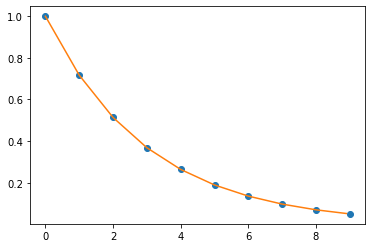

In [14]:
from scipy import interpolate
x = np.arange(0, 10)
y = np.exp(-x/3.0)
f = interpolate.interp1d(x, y)

xnew = np.arange(0, 9, 0.1)
ynew = f(xnew)   # use interpolation function returned by `interp1d`
plt.plot(x, y, 'o', xnew, ynew, '-')
plt.show()

### Identifying Outliers  
Now that the data is loaded and missing data is deleted, we need to identify rows that likely are not representative of the true data that we are trying to learn about. This may include faulty measurements due to sensor error, operator error, or simply drillruns that are abnormal. These rows are called outliers.

Histograms and boxplots are great ways of looking for outliers. Histograms plot the frequency (count) of data points within a given measurement range. For example, we may see 10 rows that have ROP within 3-4 ft/min. Boxplots are particularly helpful in identifying outliers by using quartiles ranges. For more information on identifying outliers from plots, see this article:  .

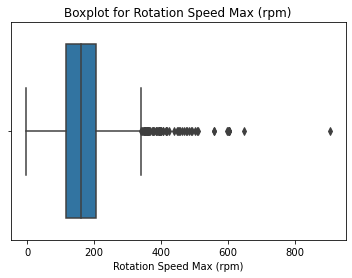

Rotation Speed Max (rpm) -- Median (Q2): 162.0, Max: 340.0, Min: 0



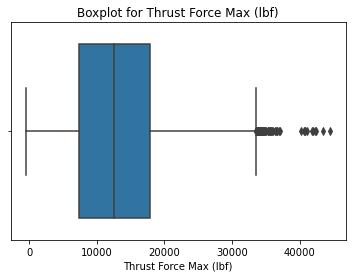

Thrust Force Max (lbf) -- Median (Q2): 12550.0, Max: 33487.5, Min: 0



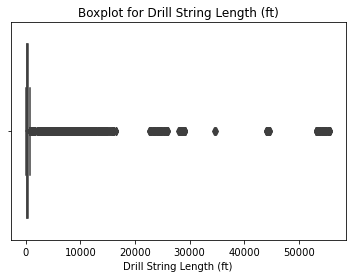

Drill String Length (ft) -- Median (Q2): 214.0, Max: 764.0, Min: 0



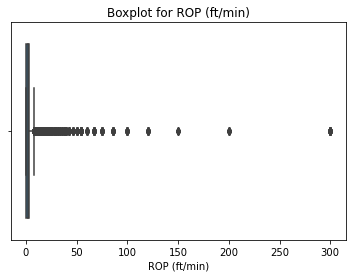

ROP (ft/min) -- Median (Q2): 1.5625, Max: 7.591371255839517, Min: 0



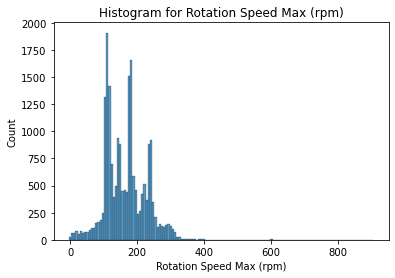

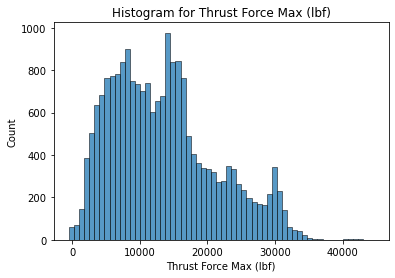

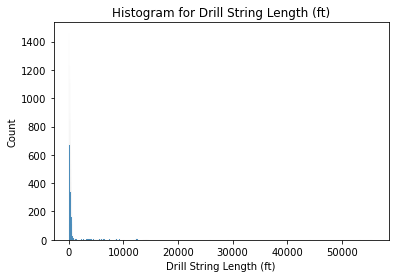

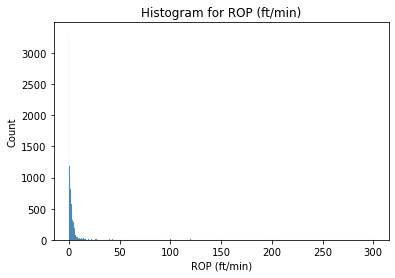

In [15]:
def histograms(columns):
    for column in columns:
        sns.histplot(data[column])
        plt.title(f'Histogram for {column}')
        plt.show()
        print('')

def boxplots(columns):
    for column in columns:
        sns.boxplot(data[column])
        plt.title(f'Boxplot for {column}')
        plt.show()
        
        # Calculate quartile ranges
        Q1 = data[column].quantile(0.25)
        Q2 = data[column].quantile(0.5)
        Q3 = data[column].quantile(0.75)

        # Calculate Inter-Quartile Range (IQR)
        IQR = Q3 - Q1
        max_ = Q3 + 1.5*IQR
        min_ = Q1 - 1.5*IQR
        
        min_ = min_ if min_ > 0 else 0

        print(f"{column} -- Median (Q2): {Q2}, Max: {max_}, Min: {min_}")
        print('')

columns = ['Rotation Speed Max (rpm)', 'Thrust Force Max (lbf)', 'Drill String Length (ft)', 'ROP (ft/min)']
boxplots(columns)
histograms(columns)

### Removing Outliers
As you can see from the plots above, there are many outliers in the data that need to be removed. Removing outliers can be very subjective in approach but mathematical principles can be employed to keep the process uniform. We will use the bounds of the boxplots as good boundaries for outlier regions. Below are two functions to help you calculate the data. A typical value for the outlier range is 1.5 (as seen in the boxplot), but we use a value of 2.5 to be inclusive of rows that are extreme but may not be outliers.

In [16]:
def calculate_bounds(data, outlier_range=1.5):
    bounds = {}
    for column in data.columns:
        try:
            Q1 = data[column].quantile(0.25)
            Q2 = data[column].quantile(0.5)
            Q3 = data[column].quantile(0.75)

            IQR = Q3 - Q1
            max_ = Q3 + outlier_range*IQR
            min_ = Q1 - outlier_range*IQR
            
            min_ = min_ if min_ > 0 else 0

            bounds[column] = {'min_': min_, 'max_': max_}
        except TypeError:
            pass
    return bounds

def delete_outliers(data, outlier_range=1.5):
    bounds = calculate_bounds(data, outlier_range=outlier_range)
    for column in bounds.keys():
        data = data[(data[column] <= bounds[column]['max_']) & (data[column] >= bounds[column]['min_'])]
    return data

In [17]:
data = delete_outliers(data, outlier_range=2.5)

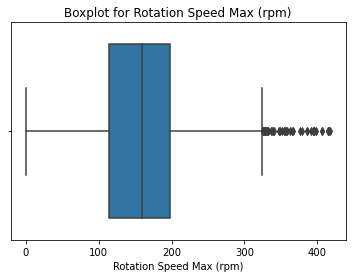

Rotation Speed Max (rpm) -- Median (Q2): 159.0, Max: 324.0, Min: 0



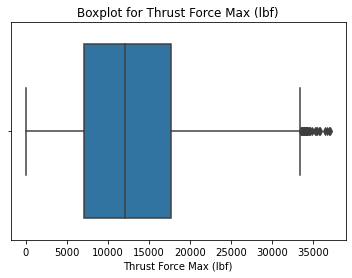

Thrust Force Max (lbf) -- Median (Q2): 12075.0, Max: 33533.0, Min: 0



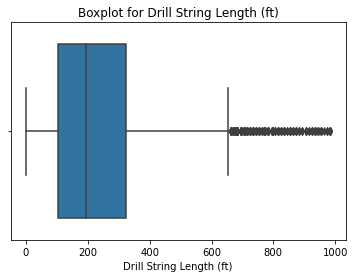

Drill String Length (ft) -- Median (Q2): 194.0, Max: 654.0, Min: 0



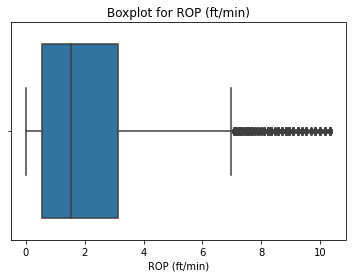

ROP (ft/min) -- Median (Q2): 1.5345268542199488, Max: 7.009286988658086, Min: 0



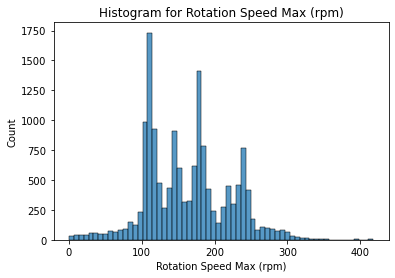

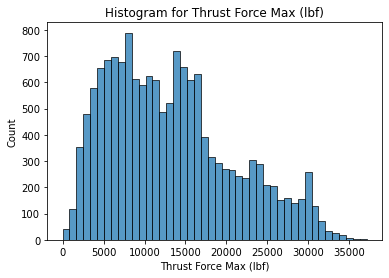

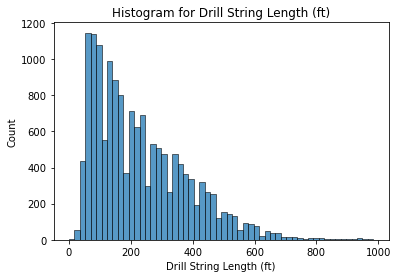

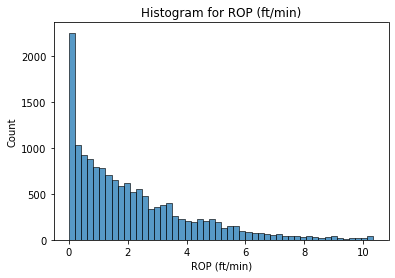

In [18]:
boxplots(columns)
histograms(columns)

The data now looks much more representative of real values and is ready to be visualized and modeled.

## Step 4: Visualizing Data

Visualization is an important step in understanding the underlying principles governing your data. There are hundreds of different kinds of plots we can use to plot data. Below are a few different functions that will help you plot the data. Try using the functions to plot different columns in the dataset and start thinking about what patterns you see may tell us about the underlying processes.

#### Plotting Functions

In [19]:
def scatterplot(data, x_column, y_column, fits=None):
    x = data[x_column]
    y = data[y_column]

    plt.scatter(x, y)
    plt.title(f'{x_column} vs {y_column}')
    plt.xlabel(str(x_column))
    plt.ylabel(str(y_column))

    if fits is None:
        return None
    
    elif "linear" in fits.lower():
        fit = np.polyfit(x,y,1, full=False)
        x_plot = np.linspace(min(x), max(x), 1000)
        plt.plot(x_plot, np.polyval(fit, x_plot), color='r', label=f'Linear Fit ($x$)')
        plt.legend()
        interpretation = f'As {column} increases by 1 unit, ROP changes by {round(fit[0],6)} ft/min'
    elif 'quadratic' in fits.lower() or 'square' in fits.lower():
        fit = np.polyfit(x,y,2, full=False)
        plt.plot(x_plot, np.polyval(fit, x_plot), color='green', label=f'Quadratic Fit ($x^2$)')
        plt.legend()
        interpretation = None
    elif 'cub' in fits.lower():
        fit = np.polyfit(x,y,3, full=False)
        plt.plot(x_plot, np.polyval(fit, x_plot), color='orange', label=f'Cubic Fit ($x^3$)')
        plt.legend()
        interpretation = None
    else:
        fit = None
        interpretation = None
    return fit, interpretation

def density(data, x_column, y_column, bins=(20,20), cmin=None, cmax=None):
    x = data[x_column]
    y = data[y_column]
    plt.hist2d(x, y, bins=(20,20), cmap=plt.cm.jet, cmin=cmin, cmax=cmax)
    plt.xlabel(str(x_column))
    plt.ylabel(str(y_column))
    plt.title(f'Density Plot of {y_column} vs {x_column}')
    plt.colorbar()
    return None


def plot_all(data, column):
    for column in columns:
        x = column
        y = 'ROP (ft/min)'
        plt.figure(figsize=(15,5))
        plt.subplot(1,2,1)

        # Scatterplots
        plt.scatter(data[x],data[y])
        plt.title(f'{x} vs {y}')
        plt.xlabel(str(x))
        plt.ylabel(str(y))
        # plt.show()

        plt.subplot(1,2,2)     
        plt.hist2d(data[x], data[y], bins=(20,20), cmap=plt.cm.jet)
        plt.title(f'{x} vs {y}')
        plt.xlabel(str(x))
        plt.ylabel(str(y))
        plt.show()

        print('')

### Make Plots

In [20]:
# Print out the available columns to plot
data.columns

Index(['Model', 'RodCount', 'Rotation Speed Max (rpm)',
       'Rotation Torque Max (ft-lb)', 'Thrust Force Max (lbf)',
       'Mud Flow Rate Avg (gpm)', 'Mud Pressure Max (psi)',
       'Pull Force Maximum (lbf)', 'Pull Speed Average (ft/min)',
       'Drill String Length (ft)', 'ROP (ft/min)'],
      dtype='object')

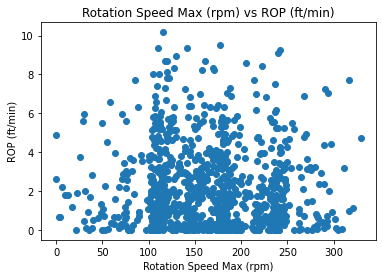

In [21]:
sample = data.sample(1000)
col = 'Rotation Speed Max (rpm)' # Change this value to plot different variables
scatterplot(sample, col, 'ROP (ft/min)')

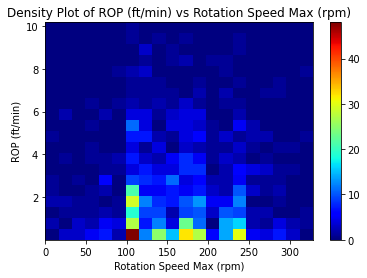

In [22]:
density(sample, x_column=col, y_column='ROP (ft/min)', bins=(20,20), cmin=None, cmax=None)

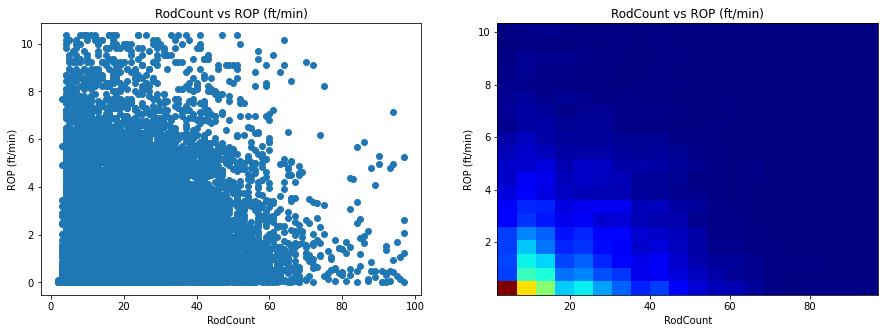

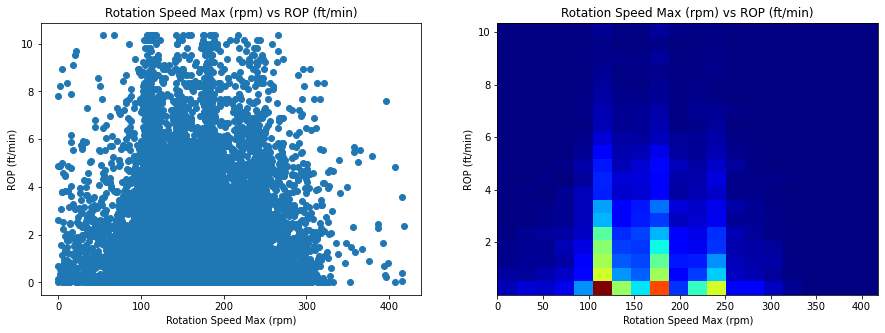

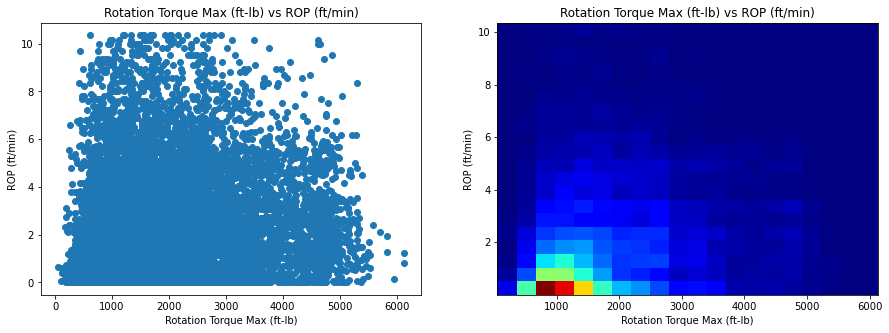

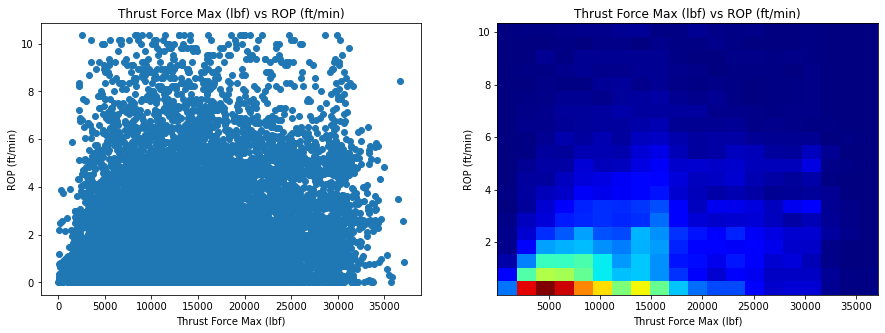

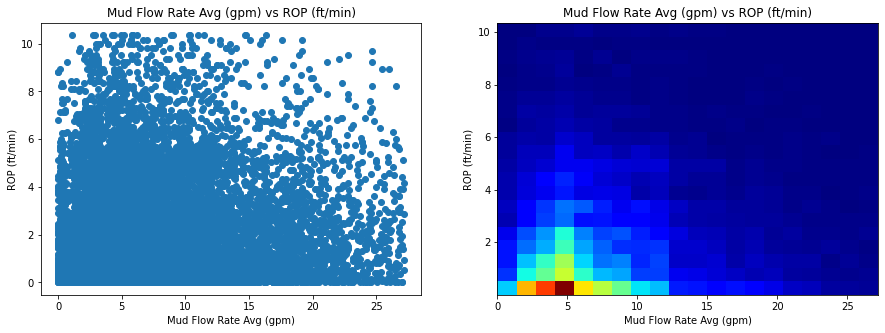

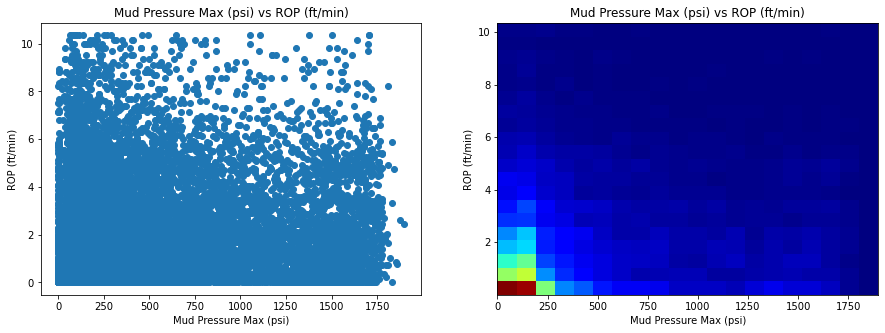

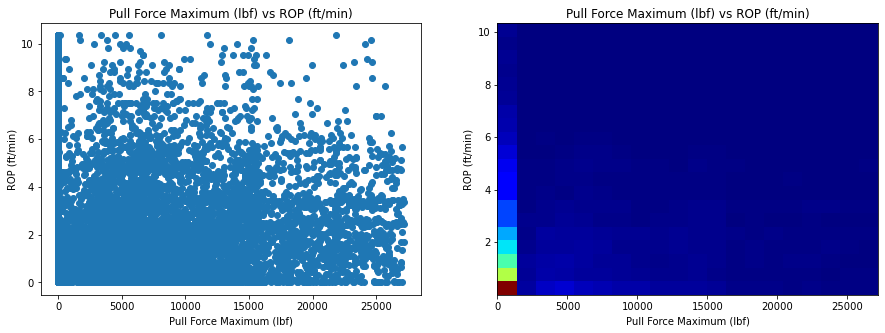

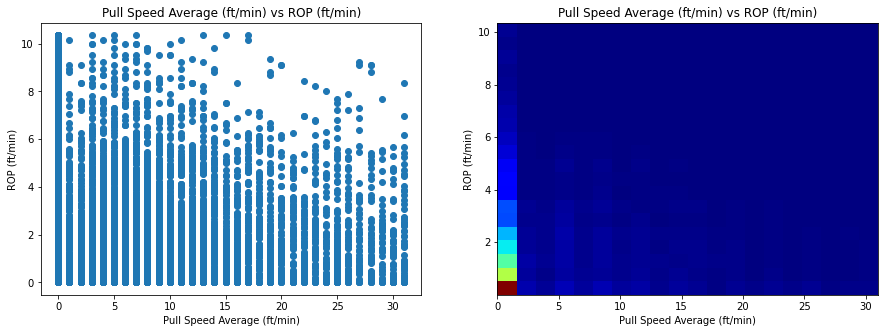

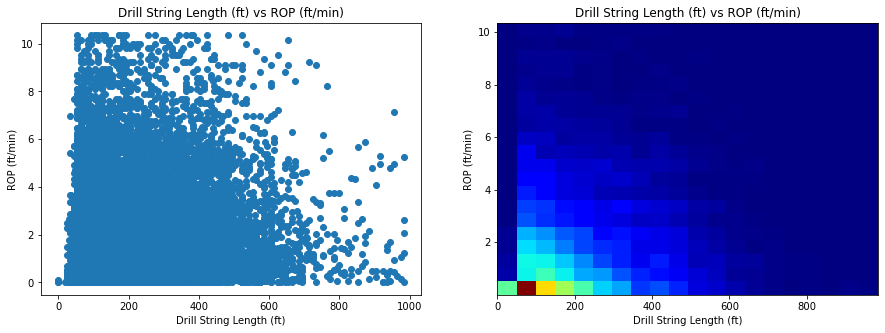

In [23]:
# Plot all columns (except for one at a time)
columns = ['RodCount','Rotation Speed Max (rpm)',
                             'Rotation Torque Max (ft-lb)', 'Thrust Force Max (lbf)', 
                             'Mud Flow Rate Avg (gpm)', 'Mud Pressure Max (psi)',
                             'Pull Force Maximum (lbf)', 'Pull Speed Average (ft/min)', 
                             'Drill String Length (ft)',]
plot_all(data, columns)

<AxesSubplot:>

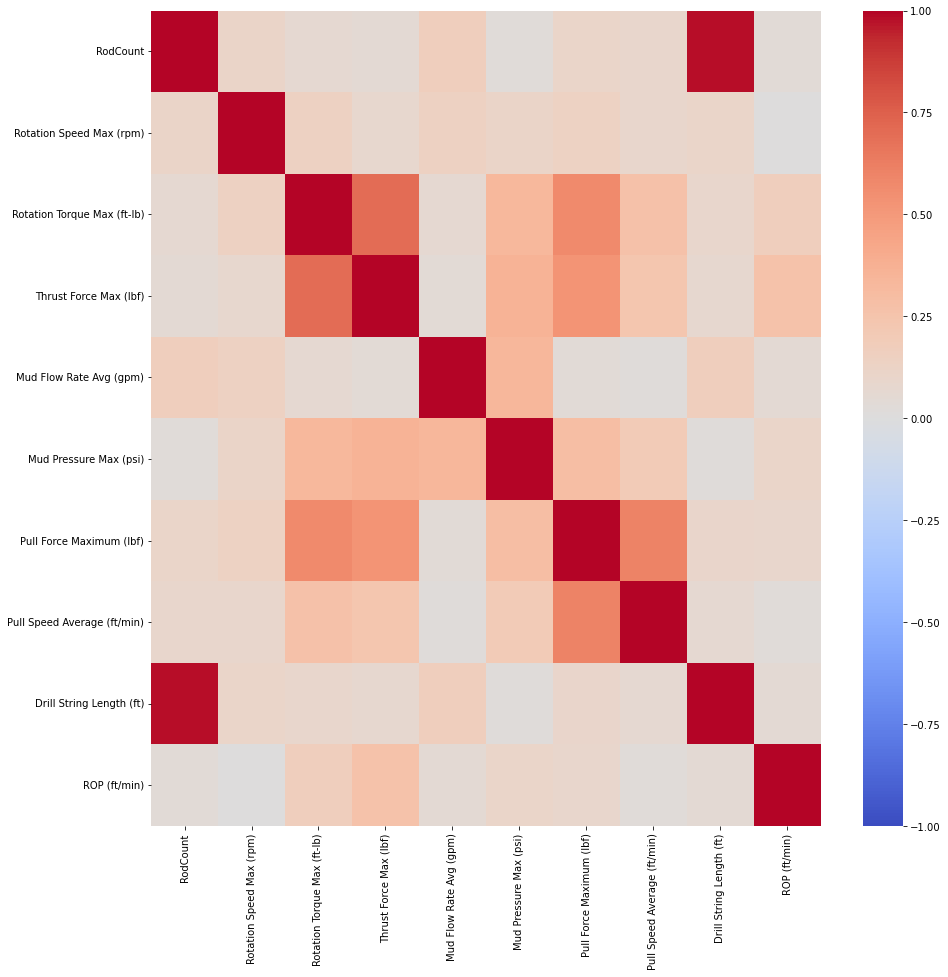

In [24]:
plt.figure(figsize=(15,15))
sns.heatmap(data.corr(), cmap='coolwarm', vmin=-1, vmax=1)

In [25]:
# smaller_sample = data.sample(300)
# profile = ProfileReport(smaller_sample)
# try:
#    profile.to_notebook_iframe()         # view as widget in Notebook
# except:
#    profile.to_file('data.html') # save as html file

<AxesSubplot:xlabel='Model', ylabel='ROP (ft/min)'>

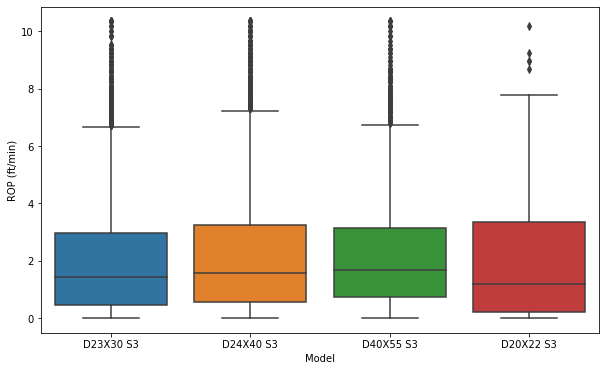

In [26]:
plt.figure(figsize=(10,6))
sns.boxplot(data['Model'], data['ROP (ft/min)'], orient='v')

## Step 5: Extracting Insights

When we visualize the data we can make qualitative assessments of the data. However, qualitative observations often need to be backed by quantitative analysis. So how can we extract insights from our data in a concrete way?

The first way to is to use summary statistics. The next cell shows a simple pandas function that gives summary statistics for the entire dataset. What do you notice? The second cell gives summary statistics for those rows whose ROP is in the top 25% (top quartile). How do they differ? Could you infer some of the reasons they may differ?

The second way is to fit functions to your data. In this example, you can use a linear fit and use the coefficient to understand the effect that a unit change in x can have on y. Try different variables to see which variables show stronger correlations with ROP.

In [27]:
data.describe()

,RodCount,Rotation Speed Max (rpm),Rotation Torque Max (ft-lb),Thrust Force Max (lbf),Mud Flow Rate Avg (gpm),Mud Pressure Max (psi),Pull Force Maximum (lbf),Pull Speed Average (ft/min),Drill String Length (ft),ROP (ft/min)
count,15323.000000,15323.000000,15323.000000,15323.000000,15323.000000,15323.000000,15323.000000,15323.000000,15323.000000,15323.000000
mean,21.562749,162.835019,1865.126215,13185.821445,7.617660,465.768583,4056.849507,3.870782,232.045552,2.114554
std,15.200553,57.670912,1075.294704,7637.371262,5.322241,474.090158,6405.898542,6.836904,153.856268,2.028770
min,2.000000,0.000000,55.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000031
25%,9.000000,114.000000,1041.000000,7053.000000,3.800000,114.000000,0.000000,0.000000,104.000000,0.535475
50%,18.000000,159.000000,1591.000000,12075.000000,6.200000,255.000000,0.000000,0.000000,194.000000,1.534527
75%,31.000000,198.000000,2474.000000,17645.000000,10.200000,693.000000,6470.500000,6.000000,324.000000,3.125000
max,97.000000,418.000000,6133.000000,37125.000000,27.200000,1898.000000,27196.000000,31.000000,984.000000,10.344828


In [28]:
# What is the data like when ROP is in the top 25%?
data[data['ROP (ft/min)'] > data['ROP (ft/min)'].quantile(0.75)].describe()

,RodCount,Rotation Speed Max (rpm),Rotation Torque Max (ft-lb),Thrust Force Max (lbf),Mud Flow Rate Avg (gpm),Mud Pressure Max (psi),Pull Force Maximum (lbf),Pull Speed Average (ft/min),Drill String Length (ft),ROP (ft/min)
count,3813.000000,3813.000000,3813.000000,3813.000000,3813.000000,3813.000000,3813.000000,3813.000000,3813.000000,3813.000000
mean,22.049830,163.864673,2133.460005,16257.750066,8.015316,544.757671,5033.923158,4.237870,240.345135,5.028551
std,14.706596,55.829047,1086.960044,7461.286992,5.402258,492.396319,7068.853973,6.732508,150.612980,1.661198
min,3.000000,0.000000,237.000000,265.000000,0.000000,0.000000,0.000000,0.000000,34.000000,3.141361
25%,10.000000,116.000000,1298.000000,10580.000000,4.200000,148.000000,0.000000,0.000000,114.000000,3.680982
50%,19.000000,160.000000,1906.000000,15447.000000,6.700000,359.000000,0.000000,0.000000,204.000000,4.615385
75%,31.000000,194.000000,2692.000000,21589.000000,10.700000,821.000000,8410.000000,7.000000,334.000000,5.769231
max,97.000000,416.000000,5393.000000,36672.000000,27.200000,1845.000000,27148.000000,31.000000,984.000000,10.344828


In [29]:
# How does each model perform?
data.groupby('Model').mean()

# data.groupby('Id').mean()  --  we deleted this but could this be useful?

,RodCount,Rotation Speed Max (rpm),Rotation Torque Max (ft-lb),Thrust Force Max (lbf),Mud Flow Rate Avg (gpm),Mud Pressure Max (psi),Pull Force Maximum (lbf),Pull Speed Average (ft/min),Drill String Length (ft),ROP (ft/min)
Model,,,,,,,,,,
D20X22 S3,29.066667,152.622222,1659.388889,9948.644444,9.553333,292.800000,3869.027778,0.000000,300.833333,2.074195
D23X30 S3,19.399676,134.110871,1615.148188,12221.539210,6.278655,447.106905,3811.799712,3.703443,201.538850,1.998062
D24X40 S3,23.212519,196.286425,2034.314781,14431.020965,7.621599,537.434540,4860.402262,4.625490,244.502866,2.176417
D40X55 S3,21.464936,142.399528,1966.926837,12402.238368,9.995583,350.969319,2730.330411,2.731625,257.078220,2.196584


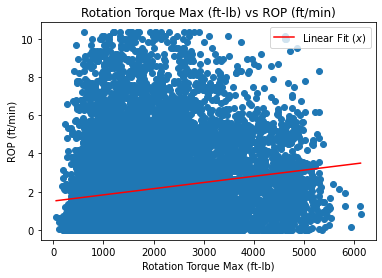

As Rotation Torque Max (ft-lb) increases by 1 unit, ROP changes by 0.000323 ft/min


In [30]:
# How does Drill String Length affect ROP?
column = 'Rotation Torque Max (ft-lb)'
fit, interpretation = scatterplot(data, column, 'ROP (ft/min)', fits='linear')
plt.show()
print(interpretation)

## Step 6: DrillGIS

Now we will look at an example of a dashboard, or a tool to view and analyze data that is generally hosted online. Click the link below and click around the website. The website shows fake drilling data that can be used to compare your drilling performance with those around you. You can also log into the website with code 571167 as a manager and 563624 as an operator.

[https://drillgis.com](https://drillgis.com)

## Step 7: Feature Engineering

The following cells show some things you can do to try and prepare the features in your dataset for a Machine Learning model. These include one-hot encoding, scaling, and other processing.

In [31]:
encoder = OneHotEncoder(sparse=False)
encoded = encoder.fit_transform(data[['Model']])
for i, model in enumerate(encoder.categories_[0]):
    data[model] = encoded[:,i]

data = data.drop(columns=['Model'])

In [32]:
data.head()

,RodCount,Rotation Speed Max (rpm),Rotation Torque Max (ft-lb),Thrust Force Max (lbf),Mud Flow Rate Avg (gpm),Mud Pressure Max (psi),Pull Force Maximum (lbf),Pull Speed Average (ft/min),Drill String Length (ft),ROP (ft/min),D20X22 S3,D23X30 S3,D24X40 S3,D40X55 S3
1,3.0,108.0,989.0,11342.0,5.4,154.0,0.0,0.0,44.0,3.208556,0.0,1.0,0.0,0.0
3,4.0,113.0,1263.0,16033.0,7.8,474.0,0.0,0.0,54.0,0.585366,0.0,1.0,0.0,0.0
4,5.0,112.0,1259.0,9954.0,7.5,165.0,0.0,0.0,64.0,5.217391,0.0,1.0,0.0,0.0
6,8.0,111.0,272.0,3479.0,8.1,148.0,448.0,0.0,94.0,0.093081,0.0,1.0,0.0,0.0
8,13.0,110.0,703.0,8990.0,7.4,483.0,0.0,0.0,144.0,0.400534,0.0,1.0,0.0,0.0


In [33]:
columns = data.columns
scaler = MinMaxScaler()
data = pd.DataFrame(scaler.fit_transform(data))
data.columns = columns

In [34]:
data.head()

,RodCount,Rotation Speed Max (rpm),Rotation Torque Max (ft-lb),Thrust Force Max (lbf),Mud Flow Rate Avg (gpm),Mud Pressure Max (psi),Pull Force Maximum (lbf),Pull Speed Average (ft/min),Drill String Length (ft),ROP (ft/min),D20X22 S3,D23X30 S3,D24X40 S3,D40X55 S3
0,0.010526,0.258373,0.153669,0.305434,0.198529,0.081138,0.000000,0.0,0.044715,0.310158,0.0,1.0,0.0,0.0
1,0.021053,0.270335,0.198750,0.431804,0.286765,0.249737,0.000000,0.0,0.054878,0.056583,0.0,1.0,0.0,0.0
2,0.031579,0.267943,0.198091,0.268042,0.275735,0.086934,0.000000,0.0,0.065041,0.504346,0.0,1.0,0.0,0.0
3,0.063158,0.265550,0.035703,0.093613,0.297794,0.077977,0.016473,0.0,0.095528,0.008995,0.0,1.0,0.0,0.0
4,0.115789,0.263158,0.106614,0.242073,0.272059,0.254478,0.000000,0.0,0.146341,0.038715,0.0,1.0,0.0,0.0


## Step 8: ML Data Processing
The next steps are necessary for the analysis of the ML algorithms. First, we identify which data columns are the features and target. Then we split the data according to a train (80%) and a test (20%) set.

In [35]:
X = data.drop(columns=['ROP (ft/min)'])
y = data['ROP (ft/min)']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

## Step 9: ML Implementation
Now we will train and deploy a very simple ML model. How did it do? What other metrics could you use to measure your performance?

### Machine Learning

In [37]:
model = ExtraTreesRegressor()
model.fit(X_train, y_train)
test_predictions = model.predict(X_test)

In [38]:
mae = mean_absolute_error(y_test, test_predictions)
mse = mean_squared_error(y_test, test_predictions)
print(f'Mean Absolute Error (xp - x): {round(mae,6)}')
print(f'Mean Squared Error (xp - x)^2: {round(mse,6)}')

Mean Absolute Error (xp - x): 0.140731
Mean Squared Error (xp - x)^2: 0.035061


### Deploying and Using a ML Model

In [39]:
pickle.dump(model, open("model.pkl", "wb"))

In [40]:
loaded_model = pickle.load(open("model.pkl", "rb"))

In [41]:
loaded_test_predictions = loaded_model.predict(X_test)

print(f"Are the models the same?: {all(loaded_test_predictions == test_predictions)}")

Are the models the same?: True
